# Time-dependent fields and currents

It is possible to define an arbitrary time dependence for external Zeeman fields, Sloncewski and Zhang-Li currents. This is done via defining an additional time-dependent prefactor that is used to multiply the initial (fixed) field/current values. Two different mechanisms can be used:

- defining the time dependence in a Python function
- writing tcl to be added to the `mif` file

The first option, defining a Python function is generally much simpler - but a bit more limited than the second method. Nevertheless, our recommendation is to use this option unless you need advanced features. The general concept is as follows: when defining the relevant term from `micromagnetimodel` you have to pass two additional arguments `time_dependence` and `tstep`. `time_dependence` is a callable (usually a user-defined Python function) that can be called for an arbitrary timestep and returns the value of the prefactor at that timestep. This function **has to be differentiable** with respect to time (first derivatives are numerically computed internally). The function is evaluated at all time steps between zero and the simulation time separated by `tstep`. The whole list is then passed to OOMMF. Therefore, `tstep` must be choosen properly. Too small steps result in too much data to be passed to OOMMF, to large steps can result in too large derivatives that can result in a failure of the simulation (and/or extremely large runtimes). A good initial guess is somewhere between `tstep=1e-12` and `tstep=1e-13`. It is not possible to have non-uniform timesteps.

The second option, writing `tcl` that is directly passed to OOMMF allows for some advanced features. It is possible to have non-differentiable time-dependence (with some exceptions, refer to the OOMMF documentation for the details) and there is no interpolation between fixed time-steps as the `tcl` script is evaluated at exact time steps required by the simulation. To use this you have to pass a dictionary `tcl_strings` defining a fixed set of keys depending on field or current (see below).

For both methods, there are some differences in the details stemming from the different dimensionality of current (scalar) and field (vector) that are explained below.

In [10]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as mc
import numpy as np

## Zeeman field
TODO

## Slonczewski and Zhang-Li currents

From the point of view of modelling time-dependent currents both Slonczewski and Zhang-Li behave the same. Examples here use `ZhangLi` but can be directly used for `Slonczewski`.

### Python function

The callable `time_dependence` must return a single number that is used to multiply the initial values. To demonstrate this we show an example of moving a domain wall with Zhang-Li current.

In [59]:
# Definition of parameters
L = 500e-9  # sample length (m)
w = 20e-9  # sample width (m)
d = 2.5e-9  # discretisation cell size (m)
Ms = 5.8e5  # saturation magnetisation (A/m)
A = 15e-12  # exchange energy constant (J/)
D = 3e-3  # Dzyaloshinkii-Moriya energy constant (J/m**2)
K = 0.5e6  # uniaxial anisotropy constant (J/m**3)
u = (0, 0, 1)  # easy axis
gamma0 = 2.211e5  # gyromagnetic ratio (m/As)
alpha = 0.3  # Gilbert damping

# Mesh definition
p1 = (0, 0, 0)
p2 = (L, w, d)
cell = (d, d, d)
region = df.Region(p1=p1, p2=p2)
mesh = df.Mesh(region=region, cell=cell)

# Micromagnetic system definition
system = mm.System(name='domain_wall_pair')
system.energy = mm.Exchange(A=A) + \
                mm.DMI(D=D, crystalclass='Cnv_z') + \
                mm.UniaxialAnisotropy(K=K, u=u)
system.dynamics = mm.Precession(gamma0=gamma0) + mm.Damping(alpha=alpha)

Because we want to move a DW pair, we need to initialise the magnetisation in an appropriate way before we relax the system.

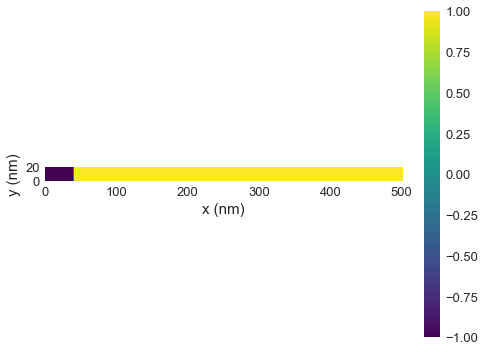

In [60]:
def m_value(pos):
    x, y, z = pos
    if x < 40e-9:
        return (0, 0, -1)
    else:
        return (0, 0, 1)
    
system.m = df.Field(mesh, dim=3, value=m_value, norm=Ms)

system.m.orientation.z.plane('z').mpl.scalar()

Now, we can relax the magnetisation.

Running OOMMF (ExeOOMMFRunner) [2021/11/12 10:05]...  <1> mmarchive killed
 <2> mmarchive killed
(3.1 s)


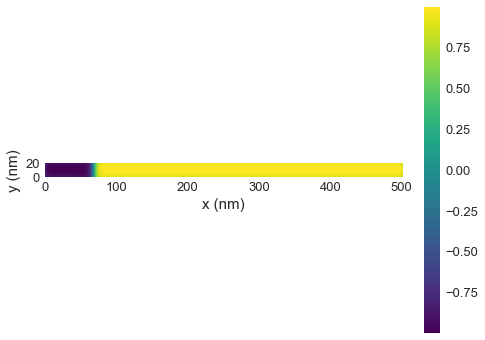

In [61]:
md = mc.MinDriver()
md.drive(system)

system.m.orientation.z.plane('z').mpl.scalar()

Now we can add the STT term to the dynamics equation. We define a sinusoidal modulation with period $T=1\,\mathrm{ns}$.

In [62]:
ux = 400  # velocity in x-direction (m/s)
beta = 0.5  # non-adiabatic STT parameter

def time_func(t):
    omega = 2 * np.pi / 1e-9
    return np.sin(omega * t)

system.dynamics += mm.ZhangLi(u=ux, beta=beta, time_dependence=time_func, tstep=1e-12)

And drive the system for $1.5 \,\text{ns}$ ($1.5T$):

Running OOMMF (ExeOOMMFRunner) [2021/11/12 10:05]...  <1> mmarchive killed
 <2> mmarchive killed
 <3> mmarchive killed
(10.1 s)


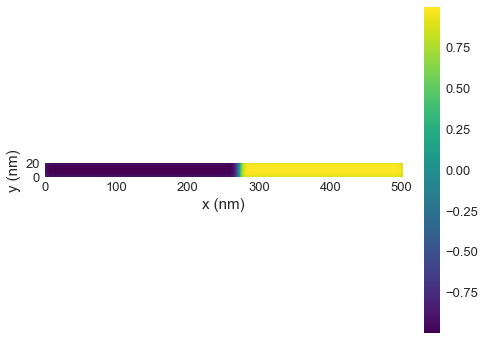

In [63]:
td = mc.TimeDriver()
td.drive(system, t=1.5e-9, n=100)

system.m.orientation.z.plane('z').mpl.scalar()

We see that the DW pair has moved to the positive $x$ direction. We can get more information about the movement by plotting the average magnetisation in z-direction as a function of time:

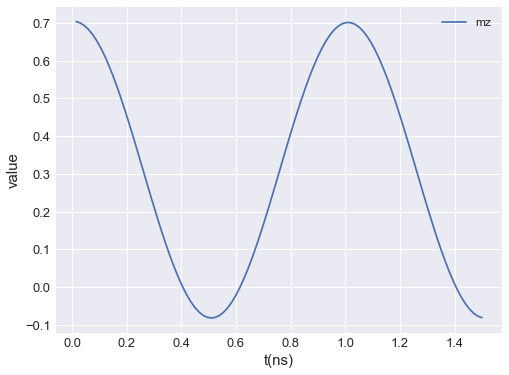

In [64]:
system.table.mpl(x='t', y=['mz'])

We can see that the magnetisation follows the sinusoidal modulation of the current. Now, let us visualise the motion using an interactive plot.

In [65]:
import micromagneticdata as md

data = md.Data(system.name)

plot = k3d.plot()

@df.interact(n=data[1].slider())
def my_plot(n):
    data[-1][n].orientation.z.plane('z').mpl.scalar()

interactive(children=(IntSlider(value=0, description='step', max=99), Output()), _dom_classes=('widget-interac…

### Tcl

TODO